In [1]:
import os
import re
import ot
import RNA
import json
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pingouin import partial_corr
from sklearn.metrics import r2_score
from sklearn.metrics import ndcg_score
from catboost import CatBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from scipy.stats import spearmanr, pearsonr, kstest
from sklearn.model_selection import KFold, train_test_split

RANDOM_STATE = 6
DATA_DIR = "/Data/"
FIGURES_DIR = "/Figures/"

2025-09-30 08:29:40.419259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759210180.718781  813112 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759210180.844015  813112 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def optimal_transport_transform(Xs, Xt):
    ot_emd = ot.da.EMDTransport()
    ot_emd.fit(Xs=Xs, Xt=Xt)
    transp_Xs_emd = ot_emd.transform(Xs=Xs)
    return transp_Xs_emd

In [2]:
full_df = pd.read_csv(
    os.path.join(DATA_DIR, "full_df_with_features.csv"), index_col=0
)
X = full_df[full_df.origin == "Large Dataset"].drop(columns=['fold_change', 'origin'])
y = full_df[full_df.origin == "Large Dataset"].fold_change
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [3]:
with open(os.path.join(DATA_DIR, f'catboost_top_features.json'), 'r') as file:
    catboost_top_features = json.load(file)

#### Figure 1

In [62]:
%%time

model = make_pipeline(RobustScaler(), CatBoostRegressor(**{
    "random_state": RANDOM_STATE,
    "task_type": "GPU",    
    "allow_writing_files": False,
    "silent": True,
    'iterations': 19837, 'learning_rate': 0.012243153247049499, 'l2_leaf_reg': 29.310656810536738, 'depth': 9, 'min_data_in_leaf': 17
}))
model.fit(X_train[catboost_top_features], y_train)  
y_pred = model.predict(X_test[catboost_top_features])
print(r2_score(y_test, y_pred))
print(pearsonr(y_test, y_pred))
print(spearmanr(y_test, y_pred))

0.39318348700176275
PearsonRResult(statistic=0.6279169306666741, pvalue=0.0)
SignificanceResult(statistic=0.6361849472209357, pvalue=0.0)
CPU times: user 2min 38s, sys: 1min 40s, total: 4min 19s
Wall time: 2min 18s


In [24]:
relevance_test = (y_test - y_test.min()) / (y_test.max() - y_test.min())
print(ndcg_score([relevance_test], [y_pred]))

0.9896139965416575


In [26]:
def sampled_ndcg(y_true, y_pred, sample_size=1000, n_samples=5, random_state=42):
    rng = np.random.default_rng(random_state)
    ndcgs = []
    n = len(y_true)
    
    for _ in range(n_samples):
        idx = rng.choice(n, size=sample_size, replace=False)
        y_true_sample = y_true[idx]
        y_pred_sample = y_pred[idx]
        
        # Convert true scores to non-negative relevance
        relevance_sample = y_true_sample - y_true_sample.min()
        
        ndcgs.append(ndcg_score([relevance_sample], [y_pred_sample]))
    
    return np.mean(ndcgs), np.std(ndcgs)

mean_ndcg, std_ndcg = sampled_ndcg(y_test.values, y_pred, sample_size=1000, n_samples=5)
print(f"Sampled NDCG: {mean_ndcg:.4f} ± {std_ndcg:.4f}")

Sampled NDCG: 0.9774 ± 0.0015


In [27]:
mean_ndcg, std_ndcg = sampled_ndcg(y_test.values, y_pred, sample_size=100, n_samples=5)
print(f"Sampled NDCG: {mean_ndcg:.4f} ± {std_ndcg:.4f}")

Sampled NDCG: 0.9605 ± 0.0114


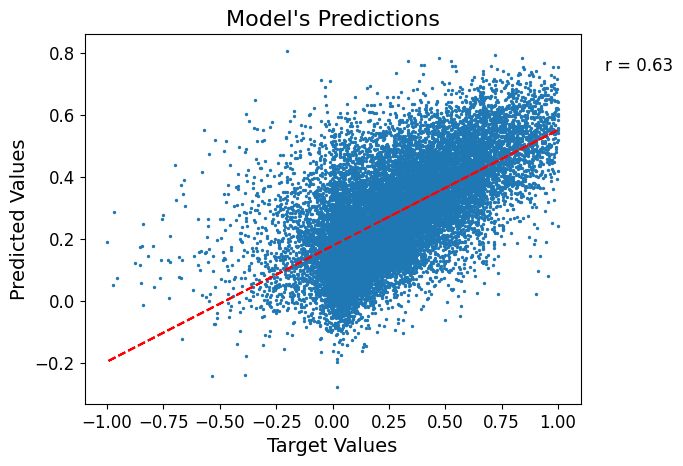

In [69]:
plt.scatter(y_test, y_pred, s=2)
plt.xlabel("Target Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Model's Predictions", fontsize=16)

r, p = pearsonr(y_test, y_pred)
plt.annotate('r = {:.2f}'.format(r), xy=(1.05, 0.90), xycoords='axes fraction', fontsize=12)

z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test),"r--")

plt.tick_params(labelsize=12)

plt.savefig(f"{FIGURES_DIR}/models predictions dot plot.png", transparent=True, bbox_inches="tight")
plt.show()

In [58]:
zika_dataset = full_df[full_df.origin.isin(['Zika a', 'Zika b'])].reset_index()
X_zika = zika_dataset[catboost_top_features]
y_zika = zika_dataset.fold_change

In [28]:
green_dataset = full_df[full_df.origin.isin(['Green 1', 'Green 2'])].reset_index()
X_green = green_dataset[catboost_top_features]
y_green = green_dataset.fold_change

In [29]:
model_green = make_pipeline(RobustScaler(), CatBoostRegressor(**{
    "random_state": RANDOM_STATE,
    "task_type": "GPU",
    "allow_writing_files": False,
    "silent": True,
    'iterations': 17327, 'learning_rate': 0.02123591982357012, 'l2_leaf_reg': 48.61997616266059, 'depth': 8, 'min_data_in_leaf': 28
}))
model_green.fit(X_train[catboost_top_features], y_train)  
y_pred = model_green.predict(X_green)

print(r2_score(y_green, y_pred))
print(pearsonr(y_green, y_pred))
print(spearmanr(y_green, y_pred))

0.45177110948340693
PearsonRResult(statistic=0.5063702177380703, pvalue=2.513087017982924e-12)
SignificanceResult(statistic=0.5239636103500507, pvalue=3.1359615078478634e-13)


In [30]:
relevance_test = (y_green - y_green.min()) / (y_green.max() - y_green.min())
print(ndcg_score([relevance_test], [y_pred]))

0.8389011228950999


#### Figure 2

In [8]:
classic_mfe_features = [feature for feature in catboost_top_features if feature.endswith("_mfe") and feature != "rRNA_mRNA_mfe"]
classic_mfe_features

['switch_mfe',
 'binding_site_mfe',
 'stem_mfe',
 'loop_to_end_mfe',
 'loop_to_stem_end_mfe',
 'stem_start_loop_end_mfe',
 'start_loop_end_mfe',
 'trigger_mfe',
 'stem_top_mfe']

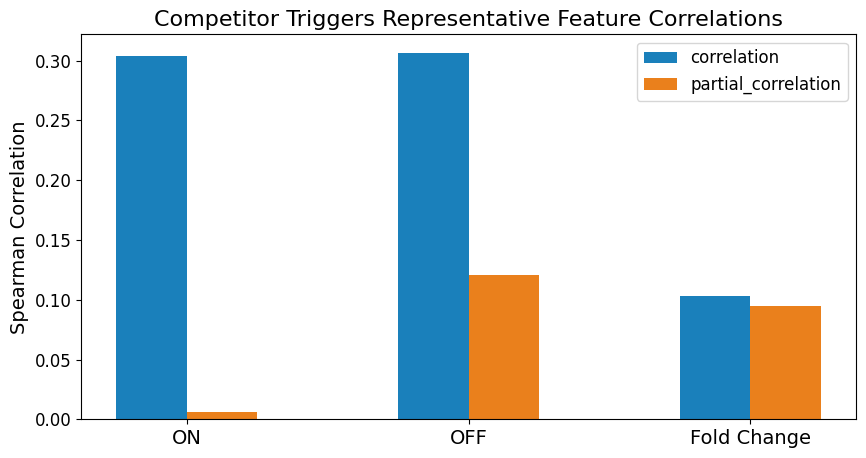

In [119]:
barWidth = 0.25
fig = plt.subplots(figsize =(10, 5)) 

feature = "mean_competitor_energy_switch"

correlations = [
    np.abs(spearmanr(X_train[feature], full_df[full_df.origin == "Large Dataset"][target].loc[y_train.index]).statistic)
    for target in ['on_value', 'off_value', 'fold_change']
] 
partial_correlations = [
    np.abs(partial_corr(
        data=pd.concat([X_train, y_train], axis=1), x=feature, y=target, covar=classic_mfe_features, method='spearman'
    ).iloc[0].r) for target in ['on_value', 'off_value', 'fold_change']
]

br1 = np.arange(len(correlations)) 
br2 = [x + barWidth for x in br1] 

plt.bar(br1, correlations, color ='#1a80bb', width = barWidth, label ='correlation') 
plt.bar(br2, partial_correlations, color ='#ea801c', width = barWidth, label ='partial_correlation') 

plt.ylabel('Spearman Correlation', fontsize = 14)
plt.yticks(fontsize=12)
plt.xticks([r + 0.5*barWidth for r in range(len(correlations))], ['ON', 'OFF', 'Fold Change'], fontsize=14)

plt.legend(fontsize=12)
plt.title("Competitor Triggers Representative Feature Correlations", fontsize=16)
plt.savefig(f"{FIGURES_DIR}/competition features partial correlation.png", transparent=True, bbox_inches="tight")
plt.show() 

#### Figure 3

In [5]:
classic_mfe_features = [feature for feature in catboost_top_features if
                        feature.endswith("_mfe") and feature != "rRNA_mRNA_mfe"]
matches_count_features = [feature for feature in catboost_top_features if
                          feature.endswith("_matches_count") and "centroid" not in feature]
ensemble_defect_features = [feature for feature in catboost_top_features if
                            feature.endswith("_ensemble_defect") and "centroid" not in feature]
probability_features = [feature for feature in catboost_top_features if
                        feature.endswith("_probability") and "centroid" not in feature]
centroid_features = [feature for feature in catboost_top_features if "centroid" in feature]
partition_function_features = [feature for feature in catboost_top_features if
                               feature.endswith("_partition_function")]
statistical_features = [feature for feature in catboost_top_features
                        if feature.endswith("_estimated_energy_mean")
                        or feature.endswith("_estimated_energy_std")]
rna_rna_interaction_features = [feature for feature in catboost_top_features
                                if "trigger_with_switch" in feature or "opening_energy" in feature
                                or "trigger_with_trigger" in feature or 'switch_with_switch_duplex_formation_energy' in feature
                                or feature == "nupack_predicted_concentration"]
gc_content_features = [feature for feature in catboost_top_features if "gc_content" in feature] + ['zCurve_3',
                                                                                                   'cumulativeSkew_1',
                                                                                                   'cumulativeSkew_2',
                                                                                                   'atgcRatio']
translation_initiation_features = [feature for feature in catboost_top_features
                                   if "translation_initiation" in feature or "_dG" in feature
                                   or "rRNA" in feature]
rnaeval_features = [feature for feature in catboost_top_features if
                    "_contribution" in feature or "interior_loop_vector_" in feature]
nucleotides_patterns_features = [feature for feature in catboost_top_features
                                 if len(re.findall("_[0-9]+", feature)) > 0
                                 and "interior_loop_vector" not in feature and "bulge" not in feature and feature not in [
                                     'zCurve_3', 'cumulativeSkew_1', 'cumulativeSkew_2', 'atgcRatio']] + [
                                    'is_au_before_hairpin']
hybridization_energy_features = [feature for feature in catboost_top_features
                                 if "hybridization_energy" in feature or "bulge" in feature]

feature_groups = {
    "classic_mfe_features": classic_mfe_features,
    "matches_count_features": matches_count_features,
    "ensemble_defect_features": ensemble_defect_features,
    "probability_features": probability_features,
    "centroid_features": centroid_features,
    "partition_function_features": partition_function_features,
    "statistical_features": statistical_features,
    "rna_rna_interaction_features": rna_rna_interaction_features,
    "gc_content_features": gc_content_features,
    "translation_initiation_features": translation_initiation_features,
    "rnaeval_features": rnaeval_features,
    "nucleotides_patterns_features": nucleotides_patterns_features,
    "hybridization_energy": hybridization_energy_features
}

In [6]:
%%time

results = {}

for groups, name in [
    ("classic_mfe_features_nucleotides_patterns_features", "classic features\n(MFE + nucleotides patterns)"),
    ("classic_mfe_features_nucleotides_patterns_features_hybridization_energy", "classic features +\nbulge energy features")
]:
    result_df = pd.read_csv(
        f"{DATA_DIR}/catboost_optuna_study_results_groups={groups}.csv",
        index_col=0
    )
    top_row = result_df[result_df.value == result_df.value.max()].iloc[0]
    model = make_pipeline(RobustScaler(), CatBoostRegressor(**{
        "random_state": RANDOM_STATE,
        "task_type": "GPU",    
        "allow_writing_files": False,
        "silent": True,
        'iterations': int(top_row.params_iterations),
        'learning_rate': float(top_row.params_learning_rate),
        'l2_leaf_reg': float(top_row.params_l2_leaf_reg),
        'depth': int(top_row.params_depth),
        'min_data_in_leaf': int(top_row.params_min_data_in_leaf)
    }))
    selected_features = [feature for feature_group, features in feature_groups.items() for feature in features if feature_group in groups]
    print(len(selected_features))
    model.fit(X_train[selected_features], y_train)  
    print("fitted")
    y_pred = model.predict(X_test[selected_features])
    results[name] = spearmanr(y_test, y_pred)

307
fitted
335
fitted
CPU times: user 1min 56s, sys: 51 s, total: 2min 47s
Wall time: 1min 31s


In [11]:
results

{'classic features\n(MFE + nucleotides patterns)': SignificanceResult(statistic=0.5652463839307894, pvalue=0.0),
 'classic features +\nbulge energy features': SignificanceResult(statistic=0.632174231343476, pvalue=0.0)}

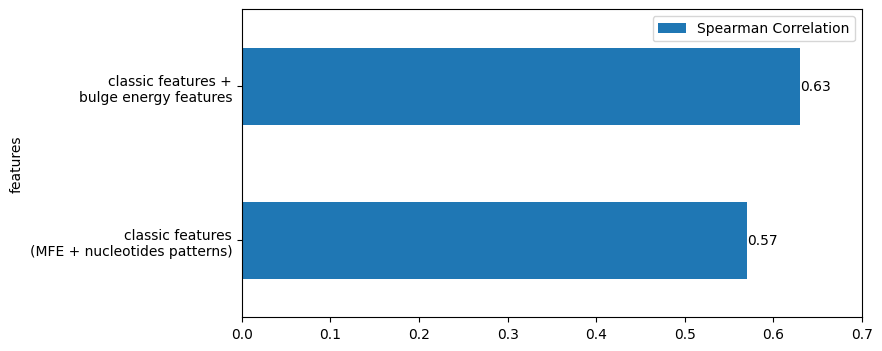

In [18]:
ax = pd.DataFrame({
    "features": list(results.keys()),
    "Spearman Correlation": [round(x.statistic, 2) for x in list(results.values())]
}).sort_values("Spearman Correlation").set_index('features').plot.barh(figsize=(8, 4))
ax.bar_label(ax.containers[0]);
ax.set_xlim([0, 0.7]);
plt.savefig(f"{FIGURES_DIR}/bulge features correlation improvement.png", transparent=True, bbox_inches="tight")

#### Figure 4

In [19]:
%%time

results = {}

for groups, name in [
    ("classic_mfe_features", "Classic MFE Features"),
    ("statistical_features", "Statistical Features"),
    ("classic_mfe_features_statistical_features_probability_features", "MFE Features +\nStatistical Features")
]:
    result_df = pd.read_csv(
        f"{DATA_DIR}/catboost_optuna_study_results_group={groups}.csv",
        index_col=0
    )
    top_row = result_df[result_df.value == result_df.value.max()].iloc[0]
    model = make_pipeline(RobustScaler(), CatBoostRegressor(**{
        "random_state": RANDOM_STATE,
        "task_type": "GPU",    
        "allow_writing_files": False,
        "silent": True,
        'iterations': int(top_row.params_iterations),
        'learning_rate': float(top_row.params_learning_rate),
        'l2_leaf_reg': float(top_row.params_l2_leaf_reg),
        'depth': int(top_row.params_depth),
        'min_data_in_leaf': int(top_row.params_min_data_in_leaf)
    }))
    selected_features = [feature for feature_group, features in feature_groups.items() for feature in features if feature_group in groups]
    print(len(selected_features))
    model.fit(X_train[selected_features], y_train)  
    print("fitted")
    y_pred = model.predict(X_test[selected_features])
    results[name] = spearmanr(y_test, y_pred)

9
fitted
17
fitted
34
fitted
CPU times: user 23.5 s, sys: 10.5 s, total: 34 s
Wall time: 19.9 s


In [20]:
results

{'Classic MFE Features': SignificanceResult(statistic=0.41558296569045655, pvalue=0.0),
 'Statistical Features': SignificanceResult(statistic=0.4374132576506104, pvalue=0.0),
 'MFE Features +\nStatistical Features': SignificanceResult(statistic=0.4620307187275073, pvalue=0.0)}

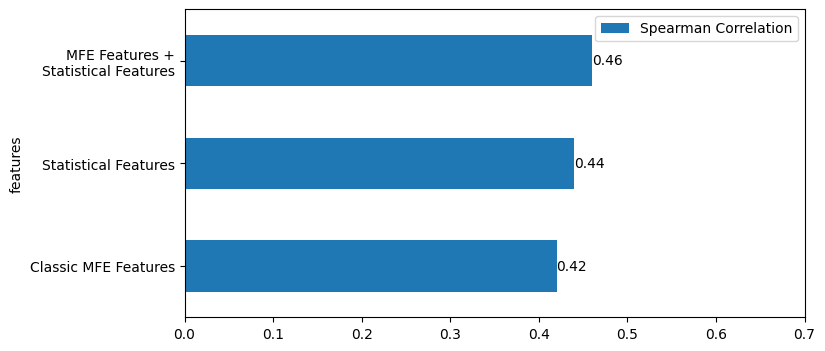

In [22]:
ax = pd.DataFrame({
    "features": list(results.keys()),
    "Spearman Correlation": [round(x.statistic, 2) for x in list(results.values())]
}).sort_values("Spearman Correlation").set_index('features').plot.barh(figsize=(8, 4))
ax.bar_label(ax.containers[0]);
ax.set_xlim([0, 0.7]);
plt.savefig(f"{FIGURES_DIR}/statistical features correlation improvement.png", transparent=True, bbox_inches="tight")

#### Figure 5

In [29]:
large_dataset = full_df[full_df.origin == "Large Dataset"]

<AxesSubplot: >

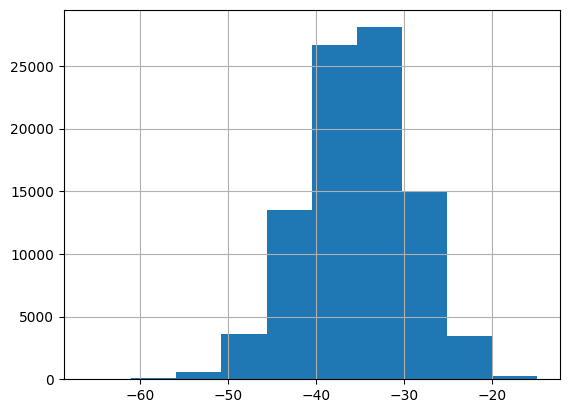

In [32]:
large_dataset.switch_mfe.hist()

In [37]:
sample_df = large_dataset[(large_dataset.switch_mfe > -35.1) & (large_dataset.switch_mfe < -34.9)]

<AxesSubplot: >

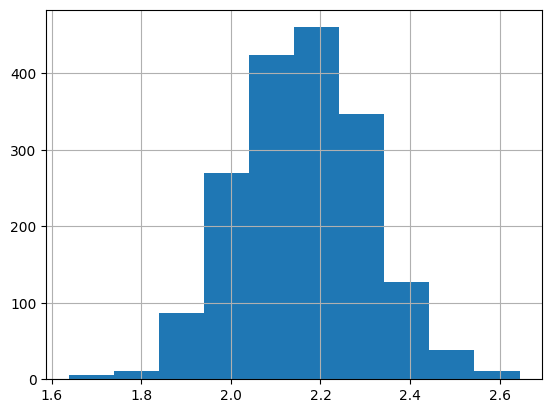

In [40]:
sample_df.switch_estimated_energy_std.hist()

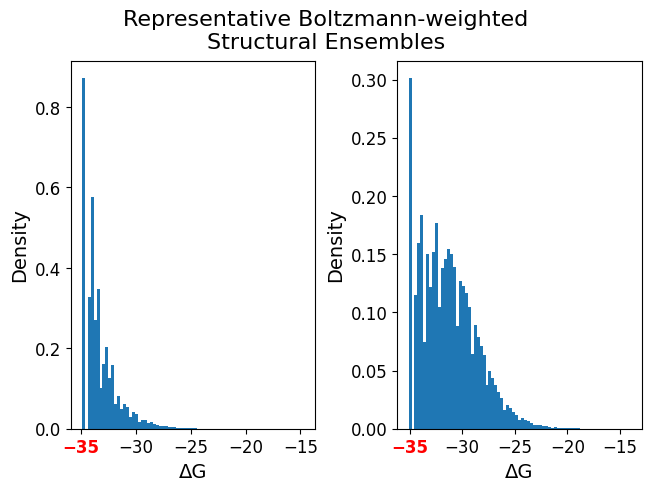

In [114]:
max_row = sample_df[sample_df.switch_estimated_energy_std == sample_df.switch_estimated_energy_std.max()].iloc[0]
min_row = sample_df[sample_df.switch_estimated_energy_std == sample_df.switch_estimated_energy_std.min()].iloc[0]

md = RNA.md()

# change temperature and dangle model
md.noLP = 1  # 20 Deg Celcius
md.dangles = 2  # Dangle Model 1
md.uniq_ML = 1

fig, axs = plt.subplots(1, 2, constrained_layout=True)

for i, sequence in enumerate([min_row.switch, max_row.switch]):
    fc = RNA.fold_compound(sequence, md)
    (mfe_structure, mfe) = fc.mfe()
    fc.exp_params_rescale(mfe)
    (pp, pf) = fc.pf()
    sampled_structures = fc.pbacktrack(1000000)
    energies = np.array([fc.eval_structure(sampled_structure) for sampled_structure in sampled_structures])
    axs[i].hist(energies, density=True, bins=75)
    axs[i].set_xlabel('ΔG', fontsize=14)
    axs[i].set_ylabel('Density', fontsize=14)
    axs[i].set_xticks(np.arange(-35, -10, 5))
    axs[i].tick_params(axis='both', which='major', labelsize=12)

    # get tick labels and highlight -35
    tick_labels = axs[i].get_xticklabels()
    
    for label in tick_labels:
        if label.get_text() == "−35":
            label.set_color("red")
            label.set_fontweight("bold")

fig.suptitle('Representative Boltzmann-weighted\nStructural Ensembles', fontsize=16)

plt.savefig(f"{FIGURES_DIR}/statistical features example.png", transparent=True, bbox_inches="tight")
plt.show()

#### Figure 6

In [7]:
synthetic_data_2_with_features = pd.read_csv(os.path.join(DATA_DIR, "optimal_transport_validation_synthetic_data_2_with_all_features.csv"), index_col=0)

In [8]:
example_features = ['switch_mfe', 'switch_gc_content']

In [13]:
X_train_ot = optimal_transport_transform(X_train[example_features].to_numpy(), synthetic_data_2_with_features[example_features].to_numpy())

/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]


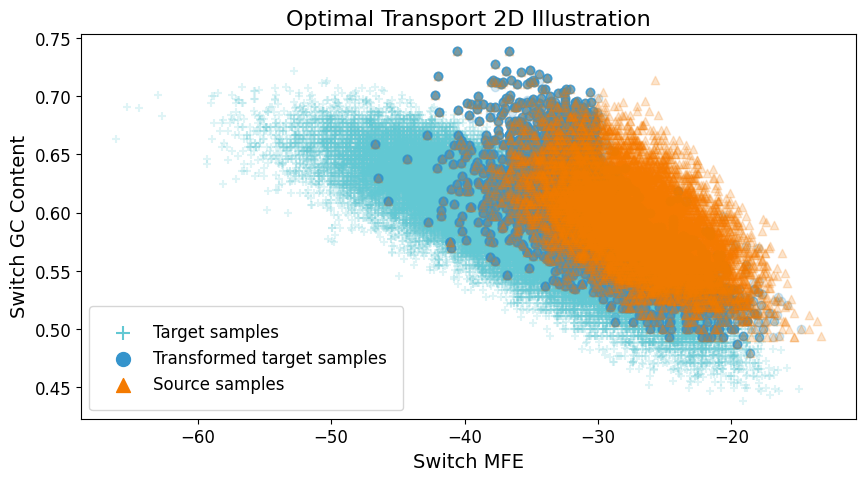

In [79]:
plt.figure(1, (10, 5))
plt.clf()
plt.scatter(X_train[example_features].to_numpy()[:, 0], X_train[example_features].to_numpy()[:, 1],
            c="#62c8d3", marker="+", label="Target samples", alpha=0.2)
plt.scatter(X_train_ot[X_train_ot[:, 0] != 0][:, 0], X_train_ot[X_train_ot[:, 0] != 0][:, 1],
            c="#3594cc", marker="o", label="Transformed target samples", alpha=0.2)
plt.scatter(synthetic_data_2_with_features[example_features].to_numpy()[:, 0],
            synthetic_data_2_with_features[example_features].to_numpy()[:, 1], c="#f47a00", marker="^", label="Source samples", alpha=0.2)
plt.legend(loc=0)
plt.xlabel("Switch MFE", fontsize=14)
plt.ylabel("Switch GC Content", fontsize=14)
plt.title("Optimal Transport 2D Illustration", fontsize=16)

legend = plt.legend(loc=0, fontsize=12, frameon=True, framealpha=0.8, borderpad=1)
for handle in legend.legendHandles:
    handle.set_alpha(1)  # Make legend symbols fully opaque
    handle.set_sizes([100]) if hasattr(handle, "set_sizes") else None  # Adjust size if scatter

# Tweak tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig(f"{FIGURES_DIR}/OT 2D example - larger font.png", transparent=True, bbox_inches="tight")
plt.show()

#### Figure 7

In [98]:
partial_dependence_df = pd.read_csv(f"{DATA_DIR}/partial_dependence_df.csv", index_col=0)

/tmp/ipykernel_3947397/1042040586.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


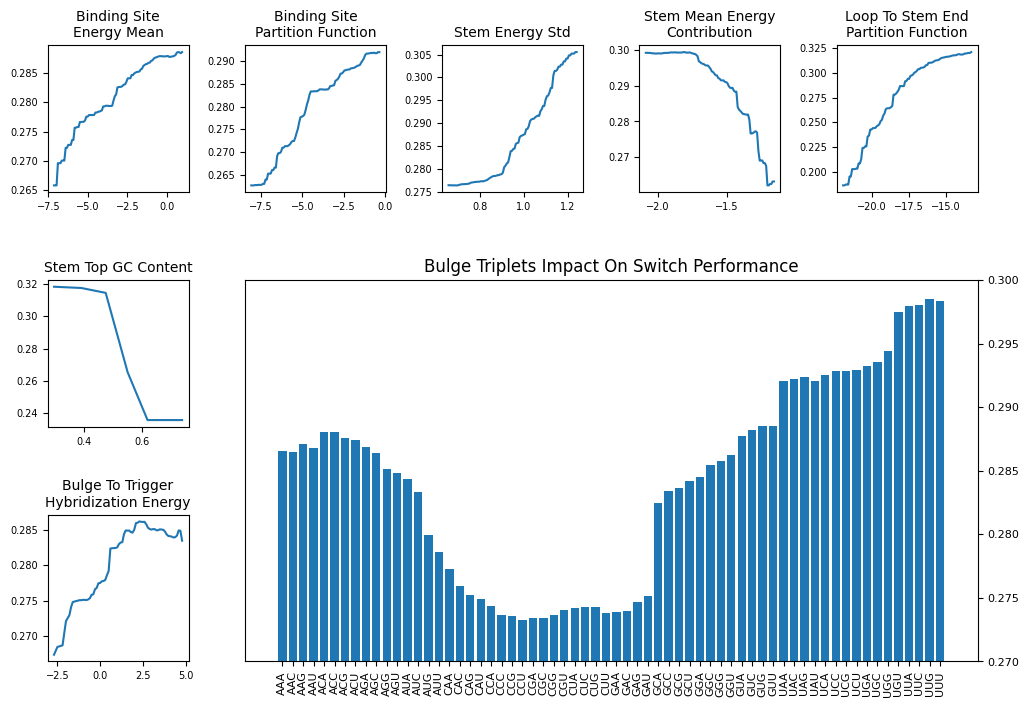

In [31]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

features_to_plot = [
    'binding_site_estimated_energy_mean', 'binding_site_partition_function', 'stem_estimated_energy_std', 'stem_mean_energy_contribution',
    'loop_to_stem_end_partition_function', 'stem_top_gc_content', 'bulge_to_trigger_hybridization_energy'
]
names = [
    'Binding Site\nEnergy Mean', 'Binding Site\nPartition Function', 'Stem Energy Std', 'Stem Mean Energy\nContribution',
    'Loop To Stem End\nPartition Function', 'Stem Top GC Content', 'Bulge To Trigger\nHybridization Energy'
]

# Create figure and GridSpec with 3 rows and 5 columns
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(3, 5, hspace=0.6, wspace=0.4)

# Top row: 5 small subplots
for i in range(5):
    ax = fig.add_subplot(gs[0, i])
    patrial_dependence_dict = json.loads(
        partial_dependence_df.set_index("feature").loc[features_to_plot[i]].partial_dependence.replace("\n", "").replace("'", '"').replace("array(", "").replace(")", "")
    )
    ax.plot(patrial_dependence_dict["grid_values"][0], patrial_dependence_dict["average"][0])
    ax.set_title(names[i], fontsize=10)
    ax.tick_params(labelsize=7)

# Middle small plot (Row 1, Col 0)
ax6 = fig.add_subplot(gs[1, 0])
patrial_dependence_dict = json.loads(
    partial_dependence_df.set_index("feature").loc[features_to_plot[5]].partial_dependence.replace("\n", "").replace("'", '"').replace("array(", "").replace(")", "")
)
ax6.plot(patrial_dependence_dict["grid_values"][0], patrial_dependence_dict["average"][0])
ax6.set_title(names[5], fontsize=10)
ax6.tick_params(labelsize=7)

# Bottom small plot (Row 2, Col 0)
ax7 = fig.add_subplot(gs[2, 0])
s = partial_dependence_df.set_index(
    "feature").loc[features_to_plot[6]].partial_dependence.replace("\n", "").replace("'", '"').replace("array(", "").replace(")", "")
fixed_s = re.sub(r'(-?\d+)\.(\s|,|\])', r'\1.0\2', s)
patrial_dependence_dict = json.loads(
    fixed_s
)
ax7.plot(patrial_dependence_dict["grid_values"][0], patrial_dependence_dict["average"][0])
ax7.set_title(names[6], fontsize=10)
ax7.tick_params(labelsize=7)

# Large subplot (spanning rows 1 & 2, columns 1–4)
ax_large = fig.add_subplot(gs[1:3, 1:5])

triplets = []

for base_0 in "ACGU":
    for base_1 in "ACGU":
        for base_2 in "ACGU":
            triplet = f"{base_0}{base_1}{base_2}"
            triplets.append(triplet)

ax_large.bar(triplets, [0.28656821, 0.28648599, 0.28707018, 0.28682597, 0.28804986,
         0.2880846 , 0.2876029 , 0.28743366, 0.28688543, 0.28637316,
         0.28511907, 0.28482951, 0.28435697, 0.28331923, 0.27994924,
         0.27861144, 0.27726313, 0.2759563 , 0.27524178, 0.27490369,
         0.27438995, 0.2736718 , 0.27356983, 0.27325456, 0.27344834,
         0.27341415, 0.27364103, 0.27400527, 0.27421745, 0.27429834,
         0.2742442 , 0.27384003, 0.27389862, 0.27395179, 0.27469536,
         0.27511895, 0.28247968, 0.28343453, 0.28360791, 0.28417347,
         0.28451997, 0.28544927, 0.28577715, 0.28627328, 0.28772891,
         0.2882248 , 0.28848561, 0.28853774, 0.29209585, 0.29223436,
         0.29234092, 0.29204132, 0.29254   , 0.29284401, 0.29283248,
         0.29288573, 0.29320848, 0.29356067, 0.29441911, 0.29748975,
         0.2979232 , 0.29807585, 0.29849347, 0.29831739])
ax_large.tick_params(axis='x', rotation=90, labelsize=8)
ax_large.tick_params(axis='y', labelsize=8)
ax_large.set_ylim((0.27, 0.3))
ax_large.yaxis.set_ticks_position('right')
ax_large.set_title("Bulge Triplets Impact On Switch Performance")

# Final layout adjustments
plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/patrial dependence plots design rules + bulge triplets.png", transparent=True, bbox_inches="tight")
plt.show()

#### Figure 8

In [127]:
synthetic_data_1 = pd.read_csv(
    os.path.join(DATA_DIR, "optimal_transport_validation_synthetic_data.csv"), index_col=0)
synthetic_data_2 = pd.read_csv(os.path.join(DATA_DIR, "optimal_transport_validation_synthetic_data_2.csv"), index_col=0)

In [162]:
def evaluate_model_fixed(X_source_train, y_train, X_target_data, X_test, y_test, not_different_features):
    different_features = [feature for feature in X_target_data.columns if feature not in not_different_features]
    
    X_train_ot = optimal_transport_transform(X_train[different_features].to_numpy(), X_target_data[different_features].to_numpy())
    X_train_ot = np.concatenate([X_train_ot, X_train[not_different_features]], axis=1)
    
    model_ot = make_pipeline(RobustScaler(), CatBoostRegressor(**{
        "random_state": RANDOM_STATE,
        "task_type": "GPU",
        "allow_writing_files": False,
        "silent": True,
        'iterations': 19837, 'learning_rate': 0.012243153247049499, 'l2_leaf_reg': 29.310656810536738, 'depth': 9, 'min_data_in_leaf': 17
    }))
    model_ot.fit(X_train_ot, y_train)  
    y_pred = model_ot.predict(X_test[different_features + not_different_features])
    return r2_score(y_test, y_pred), pearsonr(y_test, y_pred), spearmanr(y_test, y_pred)

def get_ot_evaluation_results_fixed(synthetic_data: pd.DataFrame, catboost_top_features: List[str], sample_sizes: List[int], folds_number: int):
    evaluation_results = {}

    for fold in tqdm(range(folds_number)):
        evaluation_results[fold] = []    
        target_dfs = []
        
        X_target_data = synthetic_data[catboost_top_features + ['origin']]    
        
        for sample_size in sample_sizes[::-1]:        
            X_target_data = pd.concat([
                X_target_data[X_target_data.origin == "Zika a"].sample(int(sample_size/2), random_state=fold),
                X_target_data[X_target_data.origin == "Zika b"].sample(int(sample_size/2), random_state=fold)
            ]).sample(frac=1, random_state=RANDOM_STATE)
            target_dfs.append(X_target_data)

        final_not_different_features = set()

        for X_target_data in target_dfs:
            feature_to_distributional_difference = {
                feature: kstest(X_target_data[feature], X_train[feature]).pvalue for feature in X_target_data.drop(columns=['origin']).columns
            }
            not_different_features = [feature for feature, p_value in feature_to_distributional_difference.items() if p_value > 0.05]
            final_not_different_features = final_not_different_features.union(set(not_different_features))

        print(len(final_not_different_features))
        
        for X_target_data in target_dfs:
            evaluation_results[fold].append(evaluate_model_fixed(
                X_train[catboost_top_features],
                y_train,
                X_target_data.drop(columns=['origin']),
                X_zika[catboost_top_features],
                y_zika,
                list(final_not_different_features)
            ))

    return evaluation_results

In [169]:
%%time

shuffle_evaluation_results_fixed = get_ot_evaluation_results_fixed(
    synthetic_data_2, catboost_top_features, [50, 100, 200, 500, 1000, 1500, 2000, 3000, 5000], 10)

  0%|          | 0/10 [00:00<?, ?it/s]

284


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached befo

276


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached befo

295


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached befo

282


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached befo

285


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached befo

283


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached befo

287


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached befo

285


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached befo

281


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached befo

277


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached befo

CPU times: user 3h 29min 5s, sys: 1h 39min 1s, total: 5h 8min 7s
Wall time: 2h 52min 10s


/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


In [179]:
synthetic_data_1 = synthetic_data_1.rename(columns={"type": "origin"})
synthetic_data_1["origin"] = synthetic_data_1.origin.apply(lambda origin: "Zika a" if origin == "a" else "Zika b")

In [181]:
%%time

random_generation_evaluation_results_fixed = get_ot_evaluation_results_fixed(
    synthetic_data_1, catboost_top_features, [50, 100, 200, 500, 1000, 1500, 2000, 3000, 5000], 10)

  0%|          | 0/10 [00:00<?, ?it/s]

267


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserW

277


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserW

264


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserW

271


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached befo

270


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserW

271


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserW

271


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached befo

276


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserW

272


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/tamir2/peba/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached befo

267


/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/tamir2/peba/venv/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/tamir2/peba/venv/lib/python3.10/site-packages/ot/da.py:692: RuntimeWarning: invalid value encountered in divide
  transp = self.coupling_ / nx.sum(self.coupling_, axis=1)[:, None]
/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserW

CPU times: user 3h 29min 3s, sys: 1h 37min 24s, total: 5h 6min 28s
Wall time: 2h 50min 9s


/tamir2/peba/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


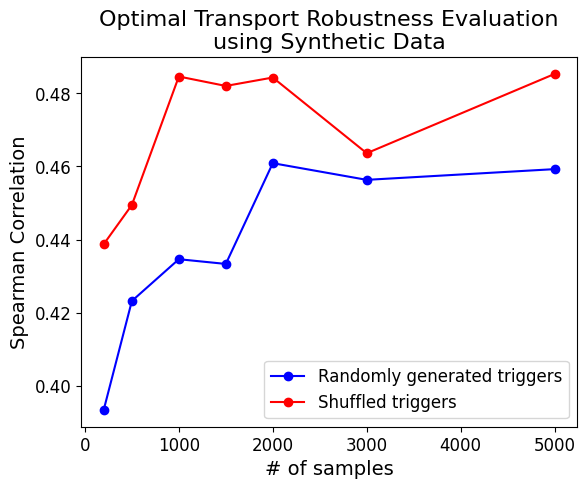

In [91]:
steps = [50, 100, 200, 500, 1000, 1500, 2000, 3000, 5000][::-1]
shuffle_results_means = [np.mean([-shuffle_evaluation_results_fixed[fold][i][2].statistic for fold in range(10)]) for i, step in enumerate(steps)]
random_generation_results_means = [np.mean([-random_generation_evaluation_results_fixed[fold][i][2].statistic 
                                            for fold in range(10)]) for i, step in enumerate(steps)]
plt.plot(steps[:-2], random_generation_results_means[:-2], color='b', marker='o', label="Randomly generated triggers")
plt.plot(steps[:-2], shuffle_results_means[:-2], color='r', marker='o', label="Shuffled triggers")
plt.legend(fontsize=12)
plt.ylabel("Spearman Correlation", fontsize=14)
plt.xlabel("# of samples", fontsize=14)
plt.tick_params(labelsize=12)
plt.title("Optimal Transport Robustness Evaluation\nusing Synthetic Data", fontsize=16)
plt.savefig(f"{FIGURES_DIR}/OT validation.png", transparent=True, bbox_inches="tight")
plt.show()

#### Figure 9

In [67]:
from scipy.stats import norm

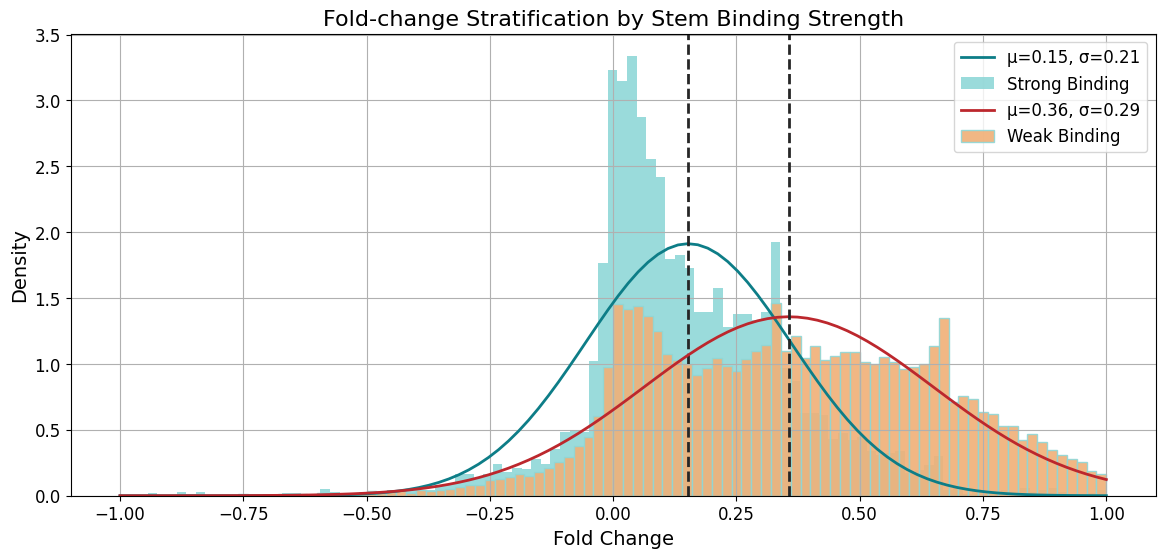

In [124]:
plt.figure(figsize=(14, 6))

values = full_df[(full_df.origin == "Large Dataset") & (full_df.stem_sides_hybridization_energy >= -35) &
(full_df.stem_sides_hybridization_energy <= -30)].fold_change

mean = values.mean()
std = values.std()

x_range = np.linspace(-1, 1, 100)
p = norm.pdf(x_range, mean, std)

# Plot normal distribution curve
plt.plot(x_range, p, '-', linewidth=2, label=f'μ={mean:.2f}, σ={std:.2f}', color='#0d7d87')

values.hist(density=True, bins=100, color='#8fd7d7', alpha=0.9, label="Strong Binding")
mean_value = values.mean()
plt.axvline(mean_value, color='#262626', linestyle='dashed', linewidth=2)

values = full_df[(full_df.origin == "Large Dataset") & (full_df.stem_sides_hybridization_energy >= -20) &
(full_df.stem_sides_hybridization_energy <= -15)].fold_change

mean = values.mean()
std = values.std()

x_range = np.linspace(-1, 1, 100)
p = norm.pdf(x_range, mean, std)

# Plot normal distribution curve
plt.plot(x_range, p, '-', linewidth=2, label=f'μ={mean:.2f}, σ={std:.2f}', color='#bc272d')

values.hist(density=True, bins=100, color='#f0b077', alpha=0.9, ec='#8fd7d7', label="Weak Binding")
mean_value = values.mean()
plt.axvline(mean_value, color='#262626', linestyle='dashed', linewidth=2)

plt.xlabel("Fold Change", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.legend(fontsize=12)
plt.title("Fold-change Stratification by Stem Binding Strength", fontsize=16)
plt.savefig(f"{FIGURES_DIR}/stem strength histograms.png", transparent=True, bbox_inches="tight")
plt.show()

In [58]:
import pandas as pd
from scipy.stats import f_oneway


def run_anova(df, feature_col, value_col):
    """
    Run one-way ANOVA to test if the means of different groups are equal.
    
    Parameters:
    df : pandas.DataFrame
        Input dataset
    feature_col : str
        Column name of the categorical partitioning feature
    value_col : str
        Column name of the continuous variable
    
    Returns:
    dict with F-statistic and p-value
    """
    groups = [group[value_col].values for name, group in df.groupby(feature_col)]
    f_stat, p_val = f_oneway(*groups)
    return {"F-statistic": f_stat, "p-value": p_val}


df = full_df[full_df.origin == "Large Dataset"].loc[X_train.index]
df["bulge_triplet"] = df.switch.apply(lambda sequence: sequence[24:27])
result = run_anova(df, "bulge_triplet", "fold_change")
print(result)

{'F-statistic': 66.54164098926412, 'p-value': 0.0}


In [60]:
import numpy as np

def cohens_d(sample1, sample2):
    n1, n2 = len(sample1), len(sample2)
    mean1, mean2 = np.mean(sample1), np.mean(sample2)
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1) # ddof=1 for sample variance

    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    d = (mean1 - mean2) / pooled_std
    return d

group_b = values = full_df[(full_df.origin == "Large Dataset") & (full_df.stem_sides_hybridization_energy >= -35) & 
(full_df.stem_sides_hybridization_energy <= -30)].fold_change
group_a = full_df[(full_df.origin == "Large Dataset") & (full_df.stem_sides_hybridization_energy >= -20) &
(full_df.stem_sides_hybridization_energy <= -15)].fold_change

effect_size = cohens_d(group_a, group_b)
print(f"Cohen's d: {effect_size}")

Cohen's d: 0.7271055887457052


#### Figure 10

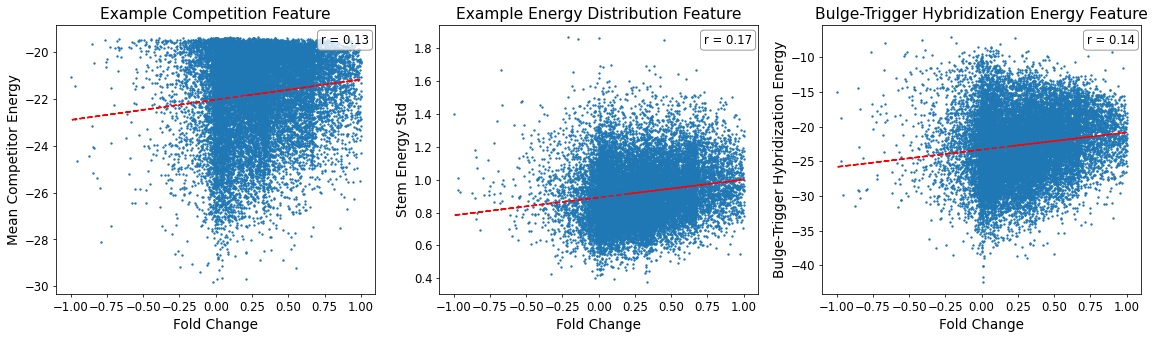

In [10]:
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(20, 5), dpi=70, linewidth=0.5)
ax = np.array(ax).flatten()

ax[0].scatter(y_test, X_test.mean_competitor_energy_switch, s=2)
ax[0].set_xlabel("Fold Change", fontsize=14)
ax[0].set_ylabel("Mean Competitor Energy", fontsize=14)
ax[0].set_title("Example Competition Feature", fontsize=16)

r, p = pearsonr(y_test, X_test.mean_competitor_energy_switch)
ax[0].annotate('r = {:.2f}'.format(r), xy=(0.83, 0.93), xycoords='axes fraction', 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8), fontsize=12)
ax[0].tick_params(axis='both', which='major', labelsize=12)

z = np.polyfit(y_test, X_test.mean_competitor_energy_switch, 1)
p = np.poly1d(z)
ax[0].plot(y_test, p(y_test),"r--")


ax[1].scatter(y_test, X_test.stem_estimated_energy_std, s=2)
ax[1].set_xlabel("Fold Change", fontsize=14)
ax[1].set_ylabel("Stem Energy Std", fontsize=14)
ax[1].set_title("Example Energy Distribution Feature", fontsize=16)

r, p = pearsonr(y_test, X_test.stem_estimated_energy_std)
ax[1].annotate('r = {:.2f}'.format(r), xy=(0.83, 0.93), xycoords='axes fraction', 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8), fontsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)

z = np.polyfit(y_test, X_test.stem_estimated_energy_std, 1)
p = np.poly1d(z)
ax[1].plot(y_test, p(y_test),"r--")


ax[2].scatter(y_test, X_test.stem_sides_hybridization_energy, s=2)
ax[2].set_xlabel("Fold Change", fontsize=14)
ax[2].set_ylabel("Bulge-Trigger Hybridization Energy", fontsize=14)
ax[2].set_title("Bulge-Trigger Hybridization Energy Feature", fontsize=16)

r, p = pearsonr(y_test, X_test.stem_sides_hybridization_energy)
ax[2].annotate('r = {:.2f}'.format(r), xy=(0.83, 0.93), xycoords='axes fraction', 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8), fontsize=12)
ax[2].tick_params(axis='both', which='major', labelsize=12)

z = np.polyfit(y_test, X_test.stem_sides_hybridization_energy, 1)
p = np.poly1d(z)
ax[2].plot(y_test, p(y_test),"r--")

plt.savefig(f"{FIGURES_DIR}/features correlations dot plots.png", transparent=True, bbox_inches="tight")
plt.show()

#### Figure 11

In [49]:
catboost_df = pd.read_csv(os.path.join(DATA_DIR, "catboost_cv_results.csv"), index_col=0)
lgbm_df = pd.read_csv(os.path.join(DATA_DIR, "lgbm_cv_results.csv"), index_col=0)

/tmp/ipykernel_1526946/2470351757.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


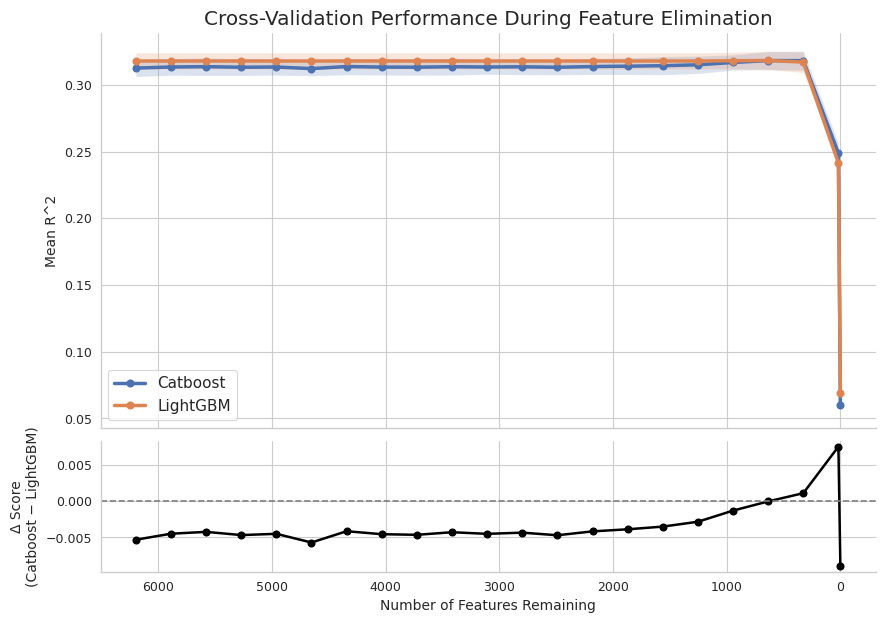

In [66]:
df_diff = catboost_df.merge(lgbm_df, on='n_features', suffixes=('_A', '_B'))
df_diff['delta_score'] = df_diff['mean_test_score_A'] - df_diff['mean_test_score_B']

sns.set(style='whitegrid', context='paper', font_scale=1.5)

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 7),
    sharex=True,
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05}
)

df_sorted = catboost_df.sort_values('n_features')
ax1.plot(df_sorted['n_features'], df_sorted['mean_test_score'],
         label="Catboost", linewidth=2.5, marker='o')
ax1.fill_between(df_sorted['n_features'],
                 df_sorted['mean_test_score'] - df_sorted['std_test_score'],
                 df_sorted['mean_test_score'] + df_sorted['std_test_score'],
                 alpha=0.2)

df_sorted = lgbm_df.sort_values('n_features')
ax1.plot(df_sorted['n_features'], df_sorted['mean_test_score'],
         label="LightGBM", linewidth=2.5, marker='o')
ax1.fill_between(df_sorted['n_features'],
                 df_sorted['mean_test_score'] - df_sorted['std_test_score'],
                 df_sorted['mean_test_score'] + df_sorted['std_test_score'],
                 alpha=0.2)

ax1.set_ylabel("Mean R^2", fontsize=10)
ax1.legend(loc='best', fontsize=11)
ax1.set_title("Cross-Validation Performance During Feature Elimination")

ax2.plot(df_diff['n_features'], df_diff['delta_score'],
         color='black',
         marker='o',
         linewidth=1.8)
ax2.axhline(0, color='gray', linestyle='--')
ax2.set_ylabel("Δ Score\n(Catboost − LightGBM)", fontsize=10)
ax2.set_xlabel("Number of Features Remaining", fontsize=10)

ax2.invert_xaxis()

for ax in [ax1, ax2]:
    ax.tick_params(
        axis='both',
        labelsize=9,       # font size of tick labels
        length=4,          # length of the ticks (default ~6)
        width=0.8,         # width of the tick lines
        pad=2              # distance of label from tick
    )

sns.despine()
plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/Cross-Validation Performance During Feature Elimination.png", transparent=True, bbox_inches="tight")
plt.show()

#### Figure 12

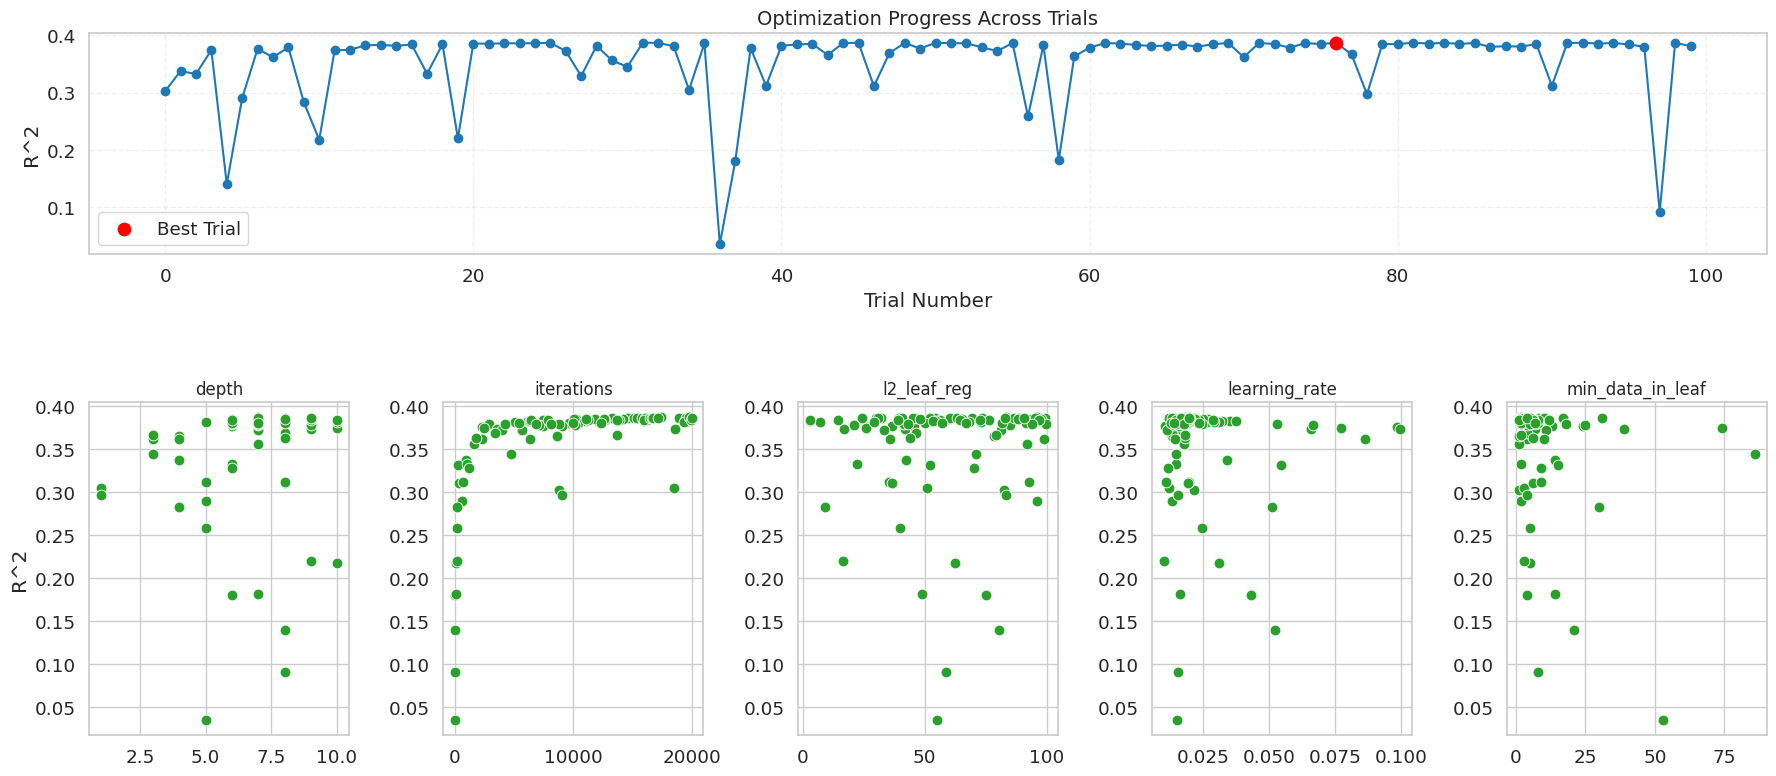

In [79]:
df = pd.read_csv(f"{DATA_DIR}/catboost_optuna_study_results.csv")

sns.set(style="whitegrid", font_scale=1.2)

# Define hyperparameter columns
hyperparams = ['params_depth', 'params_iterations', 'params_l2_leaf_reg',
               'params_learning_rate', 'params_min_data_in_leaf']

fig = plt.figure(figsize=(18, 8))
gs = fig.add_gridspec(2, len(hyperparams), height_ratios=[1, 1.5])

# --- Top plot: Optimization progress ---
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(df['number'], df['value'], marker='o', linestyle='-', color='tab:blue')

best_idx = df['value'].idxmax()
ax0.scatter(df.loc[best_idx, 'number'], df.loc[best_idx, 'value'],
            color='red', s=80, zorder=5, label='Best Trial')

ax0.set_title("Optimization Progress Across Trials", fontsize=14)
ax0.set_xlabel("Trial Number")
ax0.set_ylabel("R^2")
ax0.legend()
ax0.grid(True, linestyle='--', alpha=0.3)

# --- Bottom plots: Hyperparameter vs Value ---
for i, param in enumerate(hyperparams):
    ax = fig.add_subplot(gs[1, i])
    sns.scatterplot(data=df, x=param, y='value', ax=ax, s=60, color='tab:green')
    ax.set_title(param.replace("params_", ""), fontsize=12)
    if i == 0:
        ax.set_ylabel("R^2")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout(h_pad=3.5)
plt.savefig(f"{FIGURES_DIR}/Optuna trails.png", transparent=True, bbox_inches="tight")
plt.show()

#### Figure 13

In [40]:
risearch_benchmark_df = pd.read_csv(os.path.join(DATA_DIR, "full_df_with_risearch_analysis.csv"), index_col=0)

In [41]:
%%time

risearch_benchmark_df.risearch_results_trigger = risearch_benchmark_df.risearch_results_trigger.apply(eval)
risearch_benchmark_df.risearch_results_switch = risearch_benchmark_df.risearch_results_switch.apply(eval)
risearch_benchmark_df.risearch_results_binding_site = risearch_benchmark_df.risearch_results_binding_site.apply(eval)
risearch_benchmark_df.risearch_results_trigger_highly_expressed_genes = risearch_benchmark_df.risearch_results_trigger_highly_expressed_genes.apply(eval)
risearch_benchmark_df.risearch_results_switch_highly_expressed_genes = risearch_benchmark_df.risearch_results_switch_highly_expressed_genes.apply(eval)
risearch_benchmark_df.risearch_results_binding_site_highly_expressed_genes = risearch_benchmark_df.risearch_results_binding_site_highly_expressed_genes.apply(eval)

CPU times: user 56min 46s, sys: 2min 46s, total: 59min 33s
Wall time: 59min 47s


In [42]:
risearch_benchmark_df["mean_competitor_energy_trigger"] = risearch_benchmark_df.risearch_results_trigger.apply(
    lambda risearch_results: np.mean([result[0] for result in risearch_results]))
risearch_benchmark_df["mean_competitor_energy_switch"] = risearch_benchmark_df.risearch_results_switch.apply(
    lambda risearch_results: np.mean([result[0] for result in risearch_results]))
risearch_benchmark_df["mean_competitor_energy_binding_site"] = risearch_benchmark_df.risearch_results_binding_site.apply(
    lambda risearch_results: np.mean([result[0] for result in risearch_results]))

risearch_benchmark_df["mean_competitor_energy_trigger_highly_expressed_genes"] = risearch_benchmark_df.risearch_results_trigger_highly_expressed_genes.apply(
    lambda risearch_results: np.mean([result[0] for result in risearch_results]))
risearch_benchmark_df["mean_competitor_energy_switch_highly_expressed_genes"] = risearch_benchmark_df.risearch_results_switch_highly_expressed_genes.apply(
    lambda risearch_results: np.mean([result[0] for result in risearch_results]))
risearch_benchmark_df["mean_competitor_energy_binding_site_highly_expressed_genes"] = risearch_benchmark_df.risearch_results_binding_site_highly_expressed_genes.apply(
    lambda risearch_results: np.mean([result[0] for result in risearch_results]))

In [43]:
risearch_benchmark_df[['on_value', 'off_value', 'fold_change']] = full_df[['on_value', 'off_value', 'fold_change']]

In [44]:
classic_mfe_features = ['switch_mfe',
 'binding_site_mfe',
 'stem_mfe',
 'loop_to_end_mfe',
 'loop_to_stem_end_mfe',
 'stem_start_loop_end_mfe',
 'start_loop_end_mfe',
 'trigger_mfe',
 'stem_top_mfe']
risearch_benchmark_df[classic_mfe_features] = full_df[classic_mfe_features]

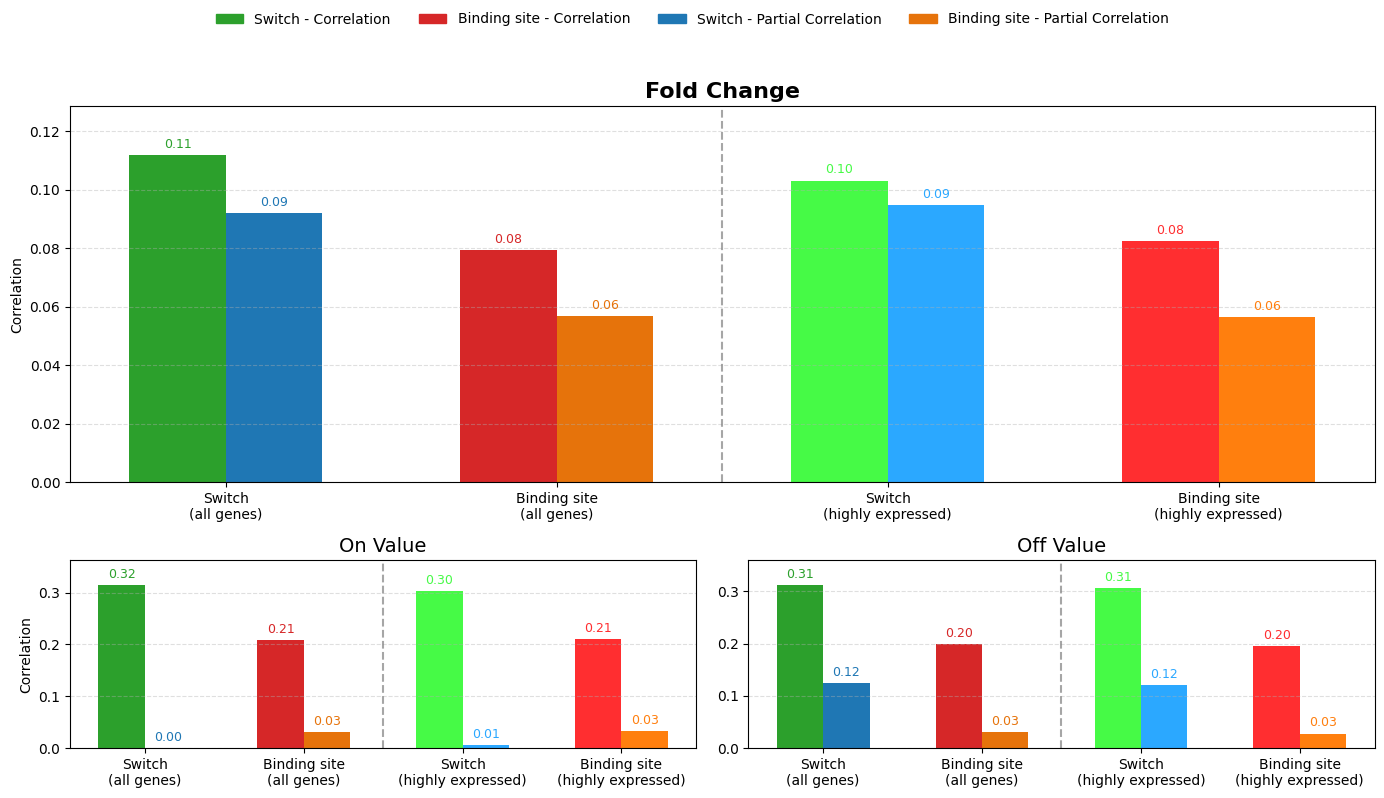

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr

# Pretty names for clarity
pretty_columns = [
    'Switch\n(all genes)',
    'Binding site\n(all genes)',
    'Switch\n(highly expressed)',
    'Binding site\n(highly expressed)'
]

columns = ['mean_competitor_energy_switch', 'mean_competitor_energy_binding_site',
           'mean_competitor_energy_switch_highly_expressed_genes', 'mean_competitor_energy_binding_site_highly_expressed_genes']

targets = ['fold_change', 'on_value', 'off_value']  # fold_change first for layout
n_cols = len(columns)

# Calculate correlations and partial correlations
correlations = [
    [np.abs(spearmanr(risearch_benchmark_df.loc[X_train.index][feature],
                      risearch_benchmark_df.loc[X_train.index][target]).statistic)
     for feature in columns]
    for target in targets
]

partial_correlations = [
    [np.abs(partial_corr(
        data=risearch_benchmark_df.loc[X_train.index],
        x=feature,
        y=target,
        covar=classic_mfe_features,
        method='spearman'
    ).iloc[0].r) for feature in columns]
    for target in targets
]

corr_colors = ['#2ca02c', '#d62728', '#46fa46', '#ff2e30']   # green/red, darker for high expr.
pcorr_colors = ['#1f77b4', '#e6730b', '#2ba8ff', '#ff7f0e']  # blue/orange, darker for high expr.

bar_width = 0.35
group_spacing = 1.2
index = np.arange(n_cols) * group_spacing

fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])

def plot_bars(ax, corr_data, pcorr_data, title, highlight=False):
    bars1 = ax.bar(index, corr_data, bar_width, color=corr_colors, label='_nolegend_')
    bars2 = ax.bar(index + bar_width, pcorr_data, bar_width, color=pcorr_colors, label='_nolegend_')
    
    ax.set_title(title, fontsize=16 if highlight else 14, fontweight='bold' if highlight else 'normal')
    
    # Centered labels
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(pretty_columns, ha='center')
    
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    
    # Separation dashed line between regular and high expr.
    ax.axvline(x=(1.5 * group_spacing) - (bar_width / 2) + 0.35, color='gray', linestyle='--', alpha=0.7)
    
    # Adjust ylim to leave space for annotations
    all_heights = [bar.get_height() for bar in bars1] + [bar.get_height() for bar in bars2]
    max_height = max(all_heights)
    ax.set_ylim(0, max_height * 1.15)  # 15% padding
    
    # Annotate bars with horizontal text, keeping inside plot area
    for bars in [bars1, bars2]:
        for bar in bars:
            h = bar.get_height()
            ax.annotate(f"{h:.2f}",
                        xy=(bar.get_x() + bar.get_width() / 2, h),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=9,
                        color=bar.get_facecolor())

# --- Top large plot: fold_change ---
ax_top = fig.add_subplot(gs[0, :])
plot_bars(ax_top, correlations[0], partial_correlations[0], "Fold Change", highlight=True)
ax_top.set_ylabel("Correlation")

# --- Bottom left: on_value ---
ax_bottom_left = fig.add_subplot(gs[1, 0])
plot_bars(ax_bottom_left, correlations[1], partial_correlations[1], "On Value")
ax_bottom_left.set_ylabel("Correlation")

# --- Bottom right: off_value ---
plot_bars(fig.add_subplot(gs[1, 1]), correlations[2], partial_correlations[2], "Off Value")

# Custom legend for categories
legend_elements = [
    plt.Rectangle((0,0),1,1, color=corr_colors[0], label='Switch - Correlation'),
    plt.Rectangle((0,0),1,1, color=corr_colors[1], label='Binding site - Correlation'),
    plt.Rectangle((0,0),1,1, color=pcorr_colors[0], label='Switch - Partial Correlation'),
    plt.Rectangle((0,0),1,1, color=pcorr_colors[1], label='Binding site - Partial Correlation')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=4, fontsize=10, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f"{FIGURES_DIR}/competition_features_comparison.png", transparent=True, bbox_inches="tight")
plt.show()

#### Figure 14

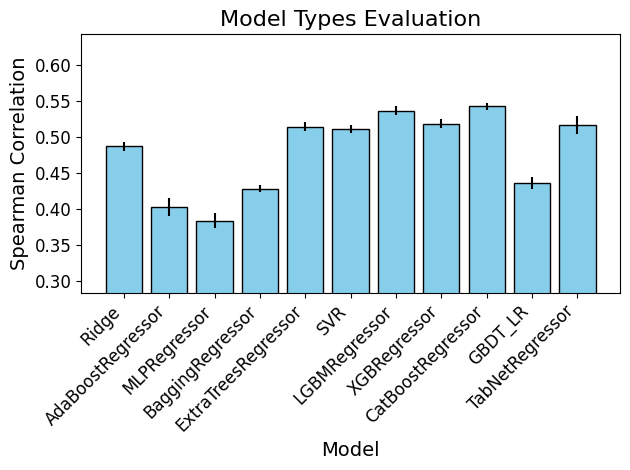

In [100]:
results_dir = os.path.join(DATA_DIR, "train_results")
all_results = {}

for file_name in os.listdir(results_dir):
    if file_name in ['ElasticNet.json', 'Lasso.json', '1dCNN.json'] or file_name[0] == "." \
    or not file_name.endswith(".json") or "top_features" in file_name or "_Stacked" in file_name:
        continue

    with open(os.path.join(results_dir, file_name)) as f:
        results = json.load(f)

    all_results[file_name.split(".")[0]] = [x[0] for x in results["spearman_results"]]

model_names = list(all_results.keys())
means = [np.mean(scores) for scores in all_results.values()]
std_devs = [np.std(scores, ddof=1) for scores in all_results.values()]

bars = plt.bar(model_names, means, yerr=std_devs, color='skyblue', edgecolor='black')

plt.title('Model Types Evaluation', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Spearman Correlation', fontsize=14)
plt.ylim(min(means) - 0.1, max(means) + 0.1)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/model types evaluation.png", transparent=True, bbox_inches="tight")
plt.show()